In [0]:
pip install nltk

In [0]:
pip install wordcloud

In [0]:
import pandas as pd
import numpy as np
import nltk
import re 
from wordcloud import WordCloud
import nltk
import re
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
stopword=set(stopwords.words('english'))
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
stress = spark.sql("SELECT * FROM global_temp.stress")
stress = stress.toPandas()
stress

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,lex_liwc_WPS,lex_liwc_Sixltr,lex_liwc_Dic,lex_liwc_function,lex_liwc_pronoun,lex_liwc_ppron,lex_liwc_i,lex_liwc_we,lex_liwc_you,lex_liwc_shehe,lex_liwc_they,lex_liwc_ipron,lex_liwc_article,lex_liwc_prep,lex_liwc_auxverb,lex_liwc_adverb,lex_liwc_conj,lex_liwc_negate,lex_liwc_verb,lex_liwc_adj,lex_liwc_compare,lex_liwc_interrog,lex_liwc_number,lex_liwc_quant,lex_liwc_affect,...,lex_liwc_motion,lex_liwc_space,lex_liwc_time,lex_liwc_work,lex_liwc_leisure,lex_liwc_home,lex_liwc_money,lex_liwc_relig,lex_liwc_death,lex_liwc_informal,lex_liwc_swear,lex_liwc_netspeak,lex_liwc_assent,lex_liwc_nonflu,lex_liwc_filler,lex_liwc_AllPunc,lex_liwc_Period,lex_liwc_Comma,lex_liwc_Colon,lex_liwc_SemiC,lex_liwc_QMark,lex_liwc_Exclam,lex_liwc_Dash,lex_liwc_Quote,lex_liwc_Apostro,lex_liwc_Parenth,lex_liwc_OtherP,lex_dal_max_pleasantness,lex_dal_max_activation,lex_dal_max_imagery,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,assistance,8lbrx9,"(0, 5)",hey rassist sure right place post goe im curr...,2606,0,1,1527009817,4,9.429736842,109,79.08,76.85,56.75,98.18,27.25,21.10,87.16,48.62,11.93,7.34,1.83,2.75,2.75,0.00,0.00,4.59,8.26,13.76,6.42,3.67,8.26,0.92,15.60,2.75,0.92,0.92,2.75,0.92,5.50,...,2.75,10.09,1.83,11.01,0.00,0.00,0.92,0.0,0.00,1.83,0.0,0.92,0.00,0.00,0.0,14.68,4.59,2.75,0.00,0.00,0.00,0.0,0.00,0.0,2.75,0.92,3.67,3.0000,2.8889,3.0,1.1250,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2.0,8.828316,0.292857
1,survivorsofabuse,9p2gbc,"[0, 5]",octob domest violenc awar month domest violenc...,1421,1,0.8,1539809005,24,7.554238095,89,32.22,28.71,84.01,1.00,17.80,31.46,88.76,52.81,15.73,11.24,7.87,0.00,0.00,3.37,0.00,4.49,4.49,8.99,13.48,4.49,4.49,2.25,13.48,4.49,2.25,1.12,1.12,1.12,7.87,...,2.25,2.25,10.11,1.12,0.00,2.25,1.12,0.0,0.00,1.12,0.0,0.00,0.00,0.00,0.0,16.85,5.62,6.74,1.12,0.00,0.00,0.0,0.00,0.0,1.12,2.25,0.00,3.0000,3.0000,3.0,1.0000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1.0,7.910952,-0.204167
2,relationships,7tx7et,"(30, 35)",think doesnt want put effort relationship work...,17554,1,1,1517274027,2,3.531123853,105,28.22,46.19,82.75,1.00,21.00,10.48,92.38,63.81,20.95,15.24,8.57,3.81,0.00,2.86,0.00,5.71,1.90,19.05,14.29,2.86,6.67,4.76,25.71,3.81,1.90,2.86,2.86,2.86,5.71,...,1.90,10.48,3.81,2.86,0.00,0.00,0.00,0.0,0.00,0.95,0.0,0.95,0.00,0.00,0.0,28.57,4.76,5.71,0.95,0.95,2.86,0.0,0.95,0.0,6.67,1.90,3.81,2.6000,2.8000,3.0,1.0000,1.1818,1.0,1.70415,1.44396,1.82046,0.75,5.0,4.338429,-0.550000
3,domesticviolence,7iphly,"[25, 30]",big compani luckili didnt see time act though ...,165,0,0.8,1512854409,6,8.331463415,119,22.47,92.33,10.42,84.87,23.80,11.76,94.96,63.87,22.69,20.17,5.88,2.52,0.00,11.76,0.00,2.52,5.04,15.13,9.24,5.04,10.92,3.36,21.01,5.04,2.52,1.68,0.84,2.52,5.04,...,0.84,7.56,7.56,1.68,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,15.13,4.20,7.56,0.00,0.00,0.00,0.0,0.00,0.0,3.36,0.00,0.00,3.0000,2.6000,3.0,1.0000,1.1250,1.0,1.66985,1.57757,1.89926,0.88,29.0,8.394244,0.277381
4,anxiety,5m3k80,"(5, 10)",clear okay monday think human brain work tri...,33053,1,0.8,1483582174,1,0.403678887,112,11.24,6.47,99,1.00,22.40,8.04,98.21,60.71,21.43,12.50,12.50,0.00,0.00,0.00,0.00,8.93,2.68,11.61,8.93,8.93,12.50,0.00,20.54,4.46,3.57,2.68,0.00,0.89,8.04,...,0.89,4.46,13.39,1.79,0.00,0.00,0.00,0.0,0.00,0.89,0.0,0.00,0.89,0.00,0.0,4.46,4.46,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,2.8333,2.5000,2.6,1.0000,1.1429,1.0,1.69549,1.44860,1.88963,1.00,0.0,1.028654,-0.079630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

### EDA

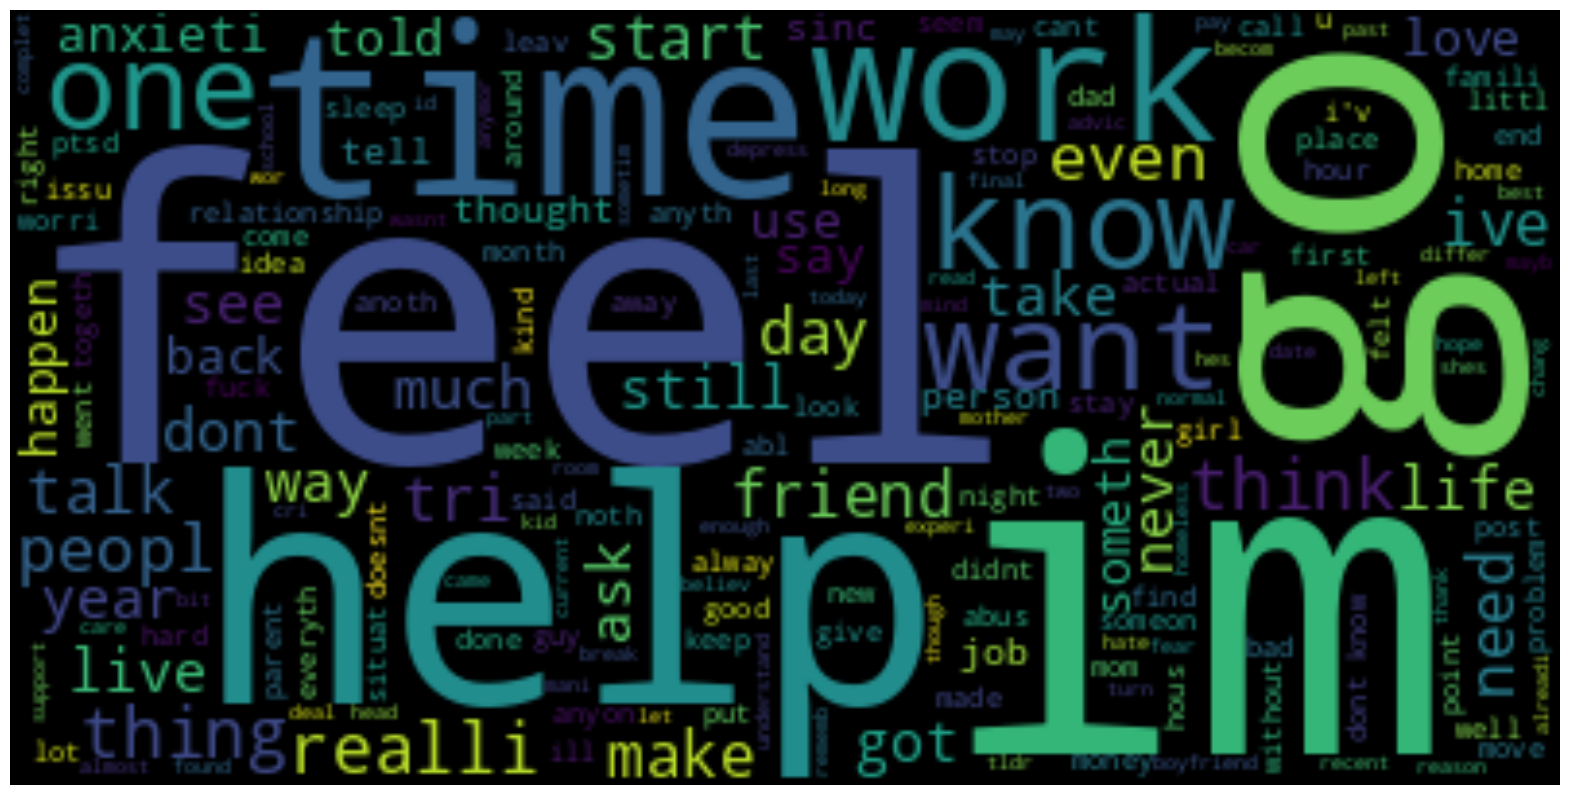

In [0]:
text = " ".join(i for i in stress.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="black").generate(text)
plt.figure( figsize=(20,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

/root/.ipykernel/5330/command-4256099086572834-835549263:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = stress[numerical_cols].corr()


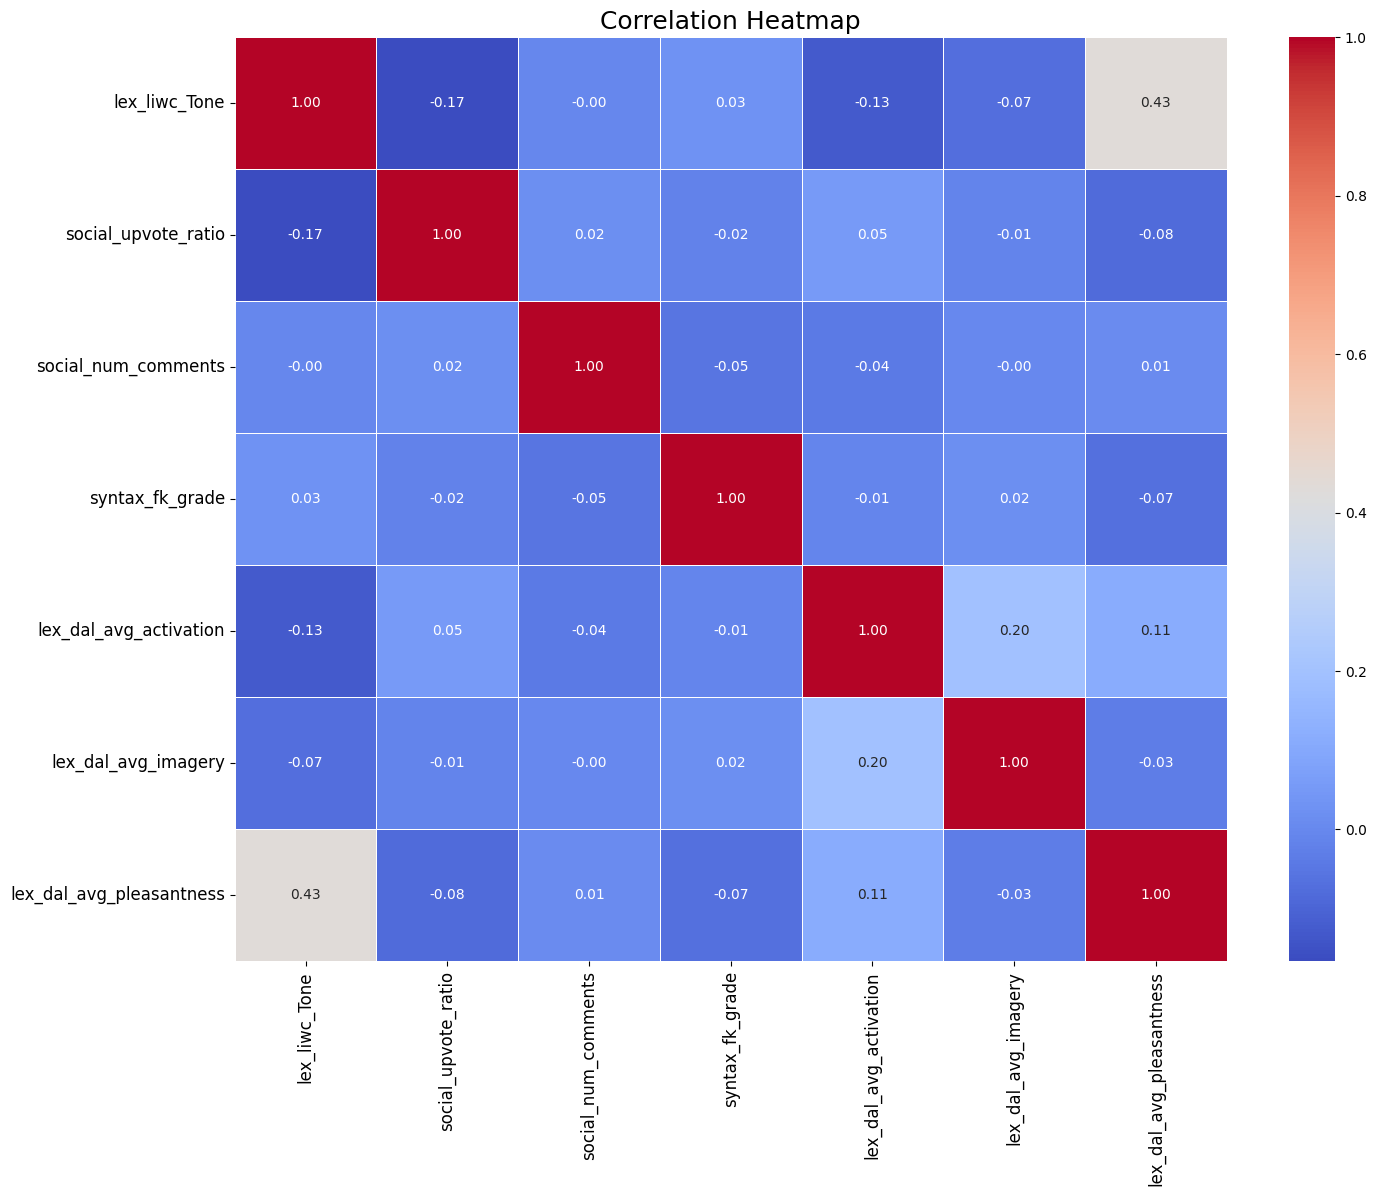

In [0]:
plt.figure(figsize=(16, 12))
numerical_cols = ['confidence', 'social_karma', 'lex_liwc_WC', 'lex_liwc_Analytic', 'lex_liwc_Clout',
                  'lex_liwc_Authentic', 'lex_liwc_Tone', 'social_upvote_ratio', 'social_num_comments',
                  'syntax_fk_grade', 'lex_dal_avg_activation', 'lex_dal_avg_imagery', 'lex_dal_avg_pleasantness']
correlation_matrix = stress[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

/databricks/python/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/databricks/python/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/databricks/python/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/databricks/python/lib/python3.10/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/databricks/python/lib/python3.10/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/databricks/python/lib/python3.10/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring

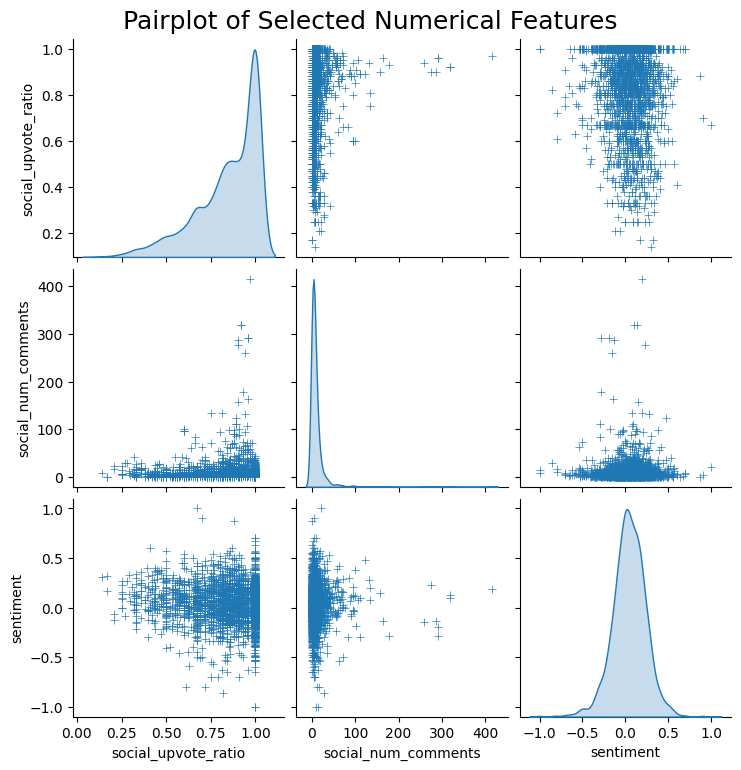

In [0]:
selected_cols = ['confidence', 'social_karma', 'social_upvote_ratio', 'social_num_comments', 'sentiment']
sns.pairplot(stress[selected_cols], diag_kind='kde', markers='+', palette='muted')
plt.suptitle('Pairplot of Selected Numerical Features', y=1.02, fontsize=18)
plt.show()

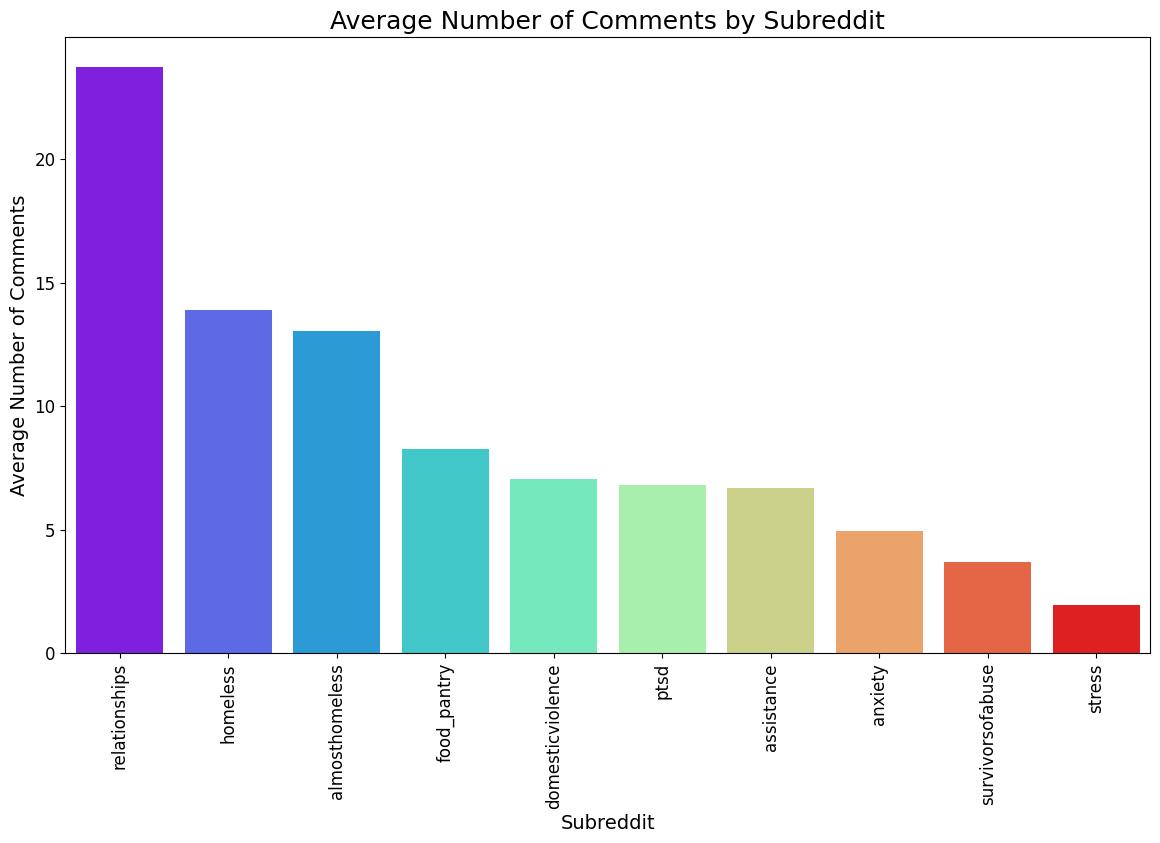

In [0]:
average_comments = stress.groupby('subreddit')['social_num_comments'].mean().sort_values(ascending=False)

# Set up the plot
plt.figure(figsize=(14, 8))

# Use Matplotlib's 'rainbow' colormap
colors = plt.cm.rainbow(np.linspace(0, 1, len(average_comments)))

# Create the barplot with the custom colors
sns.barplot(x=average_comments.index, y=average_comments.values, palette=colors)

# Customize the plot
plt.title('Average Number of Comments by Subreddit', fontsize=18)
plt.xlabel('Subreddit', fontsize=14)
plt.ylabel('Average Number of Comments', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

### Modelling

In [0]:
stress["label"] = stress["label"].map({0: "No Stress", 1: "Stress"})
stress = stress[["text", "label"]]
stress

,text,label
0,hey rassist sure right place post goe im curr...,No Stress
1,octob domest violenc awar month domest violenc...,Stress
2,think doesnt want put effort relationship work...,Stress
3,big compani luckili didnt see time act though ...,No Stress
4,clear okay monday think human brain work tri...,Stress
...,...,...
2618,week ago precious ignor jan happi year prec...,No Stress
2619,dont abil cope anymor im tri lot thing trigger...,Stress
2620,case first time your read post look peopl will...,No Stress
2621,find normal good relationship main problem see...,No Stress


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Assuming stress DataFrame is already defined and cleaned

# Extract text and labels from the DataFrame
x = stress["text"]
y = stress["label"]

# Use TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(x)

# Split the data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=42)


In [0]:
import joblib
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
model.fit(xtrain, ytrain)
# Make predictions on the test data
predictions = model.predict(xtest)

# Calculate and print the accuracy score
accuracy = accuracy_score(ytest, predictions)
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1 score specifying 'Stress' as the positive label
precision = precision_score(ytest, predictions, pos_label='Stress')
recall = recall_score(ytest, predictions, pos_label='Stress')
f1 = f1_score(ytest, predictions, pos_label='Stress')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Save the trained model to a .pkl file
model_filename = 'bernoulli_nb_model.pkl'
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")


Accuracy: 0.7923809523809524
Precision: 0.7746031746031746
Recall: 0.8652482269503546
F1 Score: 0.8174204355108877


In [0]:
%pip install azure-storage-blob

### Saving the Models to a Container

In [0]:
# from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
 
# # Set up your connection string (found in your Azure portal under Storage Account Access keys)
# connect_str = "DefaultEndpointsProtocol=https;AccountName=your_account_name;AccountKey=your_account_key;EndpointSuffix=core.windows.net"
 
# blob_name = "bernoulli_nb_model.pkl"
# path = 'bernoulli_nb_model.pkl'
# blob_service_client = BlobServiceClient.from_connection_string('DefaultEndpointsProtocol=https;AccountName=chakssa;AccountKey=igtnp8QaR6wyg8QqSrly+MZlYoTtXn7mQxYUbkYUyJKTTtuFtbe6A8GT+IrB/jurKRzR9KtIPwB5+AStruAw/A==;EndpointSuffix=core.windows.net')
# blob_client = blob_service_client.get_blob_client(container='con1', blob=blob_name)
# with open(path, "rb") as data:
#     blob_client.upload_blob(data, overwrite=True)

### Importing the Model

In [0]:
user = input("Enter a Text: ")
stress = tfidf.transform([user]).toarray()
output = model.predict(stress)
print(output)

Enter a Text:  Sometimes I feel like I need help

['Stress']


In [0]:
from sklearn.svm import SVC

# Create an SVM model
model_svm = SVC(kernel='rbf')  # You can choose other kernels such as 'rbf', 'poly', etc.

# Fit the model on the training data
model_svm.fit(xtrain, ytrain)

# Make predictions on the test data
predictions = model.predict(xtest)

# Calculate and print the accuracy score
accuracy = accuracy_score(ytest, predictions)
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1 score specifying 'Stress' as the positive label
precision = precision_score(ytest, predictions, pos_label='Stress')
recall = recall_score(ytest, predictions, pos_label='Stress')
f1 = f1_score(ytest, predictions, pos_label='Stress')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

model_filename = 'svc_model.pkl'
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")


Accuracy: 0.7923809523809524
Precision: 0.833976833976834
Recall: 0.7659574468085106
F1 Score: 0.7985212569316082
Model saved to svc_model.pkl


### Saving SVC to container

In [0]:
# from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
 
# # Set up your connection string (found in your Azure portal under Storage Account Access keys)
# connect_str = "DefaultEndpointsProtocol=https;AccountName=your_account_name;AccountKey=your_account_key;EndpointSuffix=core.windows.net"
 
# blob_name = "svc_model.pkl"
# path = 'svc_model.pkl'
# blob_service_client = BlobServiceClient.from_connection_string('DefaultEndpointsProtocol=https;AccountName=chakssa;AccountKey=igtnp8QaR6wyg8QqSrly+MZlYoTtXn7mQxYUbkYUyJKTTtuFtbe6A8GT+IrB/jurKRzR9KtIPwB5+AStruAw/A==;EndpointSuffix=core.windows.net')
# blob_client = blob_service_client.get_blob_client(container='con1', blob=blob_name)
# with open(path, "rb") as data:
#     blob_client.upload_blob(data, overwrite=True)

In [0]:
user = input("Enter a Text: ")
stress = tfidf.transform([user]).toarray()
output = model_svm.predict(stress)
print(output)

Enter a Text:  Sometimes I feel like I need help

['Stress']
